In [1]:
# import necessary libraries for data manipulation, model evaluation, and plotting
!pip install transformers[torch] accelerate -U plotting

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from transformers import TrainerCallback

import os
import pandas as pd
import datetime
import sys
from sklearn.utils import resample

import torch
from torch.optim import AdamW  # variant of Adam with weight decay
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2ForSequenceClassification, GPT2Tokenizer, TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification
from transformers import EarlyStoppingCallback

import json
import numpy as np
from transformers import EarlyStoppingCallback

from sklearn.utils.class_weight import compute_class_weight

import datetime
import sklearn
from transformers import get_linear_schedule_with_warmup
from transformers import EarlyStoppingCallback


  Using cached accelerate-0.28.0-py3-none-any.whl (290 kB)
  Using cached plotting-0.0.7-py3-none-any.whl (13 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Cell 1
# data preprocessing

# need to have separate models for each sdoh
dataset = pd.read_csv("/content/PREPROCESSED-NOTES.csv")

# extract text data and specific SDoH categories from the dataset
text_data = dataset["text"].to_list()
sdoh_data = {
    "sdoh_community_present": dataset["sdoh_community_present"].to_list(),
    "sdoh_community_absent": dataset["sdoh_community_absent"].to_list(),
    "sdoh_education": dataset["sdoh_education"].to_list(),
    "sdoh_economics": dataset["sdoh_economics"].to_list(),
    "sdoh_environment": dataset["sdoh_environment"].to_list(),
    "behavior_alcohol": dataset["behavior_alcohol"].to_list(),
    "behavior_tobacco": dataset["behavior_tobacco"].to_list(),
    "behavior_drug": dataset["behavior_drug"].to_list()
}


# prepare directories for storing train-test split data for each SDoH category
base_path = 'test_train_split/behavior_drug'
os.makedirs(base_path, exist_ok=True)

# Iterate through each SDOH data category to split and save as separate CSV files
for category, data in sdoh_data.items():
    base_path = f"test_train_split/{category}"
    os.makedirs(base_path, exist_ok=True)

    # Split data for the current category into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        text_data, data, random_state=0, train_size=0.8, stratify=data
    )

    # Save all splits as CSV files
    pd.DataFrame({"text": X_train}).to_csv(f"{base_path}/X_train.csv", index=False)
    pd.DataFrame({"text": X_val}).to_csv(f"{base_path}/X_val.csv", index=False)
    pd.DataFrame({category: y_train}).to_csv(f"{base_path}/y_train.csv", index=False)
    pd.DataFrame({category: y_val}).to_csv(f"{base_path}/y_val.csv", index=False)

In [3]:
# Cell 2
# Model training preparation
# functions for saving metrics and plotting loss
def save_metrics_to_csv(json_filepath, csv_filename):
    with open(json_filepath) as file:
        data = json.load(file)

        log_history = data['log_history']
        df = pd.DataFrame(log_history)

        df.to_csv(csv_filename, index=False)

def plot_metric_from_tensor(log_dir, output_dir, steps_per_epoch):

    # Calculate steps_per_epoch based on training data and training arguments
    # steps_per_epoch = len(train_dataset) // training_args.per_device_train_batch_size
    event_acc = event_accumulator.EventAccumulator(log_dir)
    event_acc.Reload()

    graph1_data = event_acc.Scalars("eval/loss")
    graph2_data = event_acc.Scalars("train/loss")

    '''
    # convert steps to epochs
    epochs1 = [event.step / steps_per_epoch for event in graph1_data]
    values1 = [event.value for event in graph1_data]

    epochs2 = [event.step / steps_per_epoch for event in graph2_data]
    values2 = [event.value for event in graph2_data]
    '''

    # Use actual step numbers to convert to epochs, in case of early stopping
    epochs1 = [min(event.step / steps_per_epoch, training_args.num_train_epochs) for event in graph1_data]
    values1 = [event.value for event in graph1_data]

    epochs2 = [min(event.step / steps_per_epoch, training_args.num_train_epochs) for event in graph2_data]
    values2 = [event.value for event in graph2_data]

    plt.figure(figsize=(10, 6))

    plt.plot(epochs1, values1, label="Validation Loss")
    plt.plot(epochs2, values2, label="Train Loss")

    plt.legend()

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Overlap")
    # plt.show()

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Save the graph to the specified folder
    plt.savefig(os.path.join(output_dir, 'training_validation_plot.png'))
    plt.show()

# evaluation metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def get_latest_checkpoint(folder_path):
    # Get a list of all files and directories in the specified folder
    files_and_dirs = os.listdir(folder_path)

    # Filter only directories (assumed to be checkpoints)
    checkpoint_dirs = [d for d in files_and_dirs if os.path.isdir(os.path.join(folder_path, d))]

    if not checkpoint_dirs:
        print("No checkpoint directories found.")
        return None

    # Extract the checkpoint numbers from the directory names
    checkpoint_numbers = [int(d.split('-')[1]) for d in checkpoint_dirs]

    # Identify the directory with the highest checkpoint number
    latest_checkpoint = os.path.join(folder_path, f"checkpoint-{max(checkpoint_numbers)}")

    return latest_checkpoint

checkpoint_path = '/content/checkpoints/checkpoint_epoch_{epoch}.pth'
best_model_path = '/content/checkpoints/best_model.pth'


# Saving the checkpoints
def save_checkpoint(model, optimizer, epoch, loss, val_loss, is_best=False):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'val_loss': val_loss
    }
    torch.save(checkpoint, checkpoint_path)
    if is_best:
        torch.save(model.state_dict(), best_model_path)

In [4]:
# each sdoh will have a separate model
# labels are grouped with similar values

# Define label_columns and their corresponding dictionaries for label mappings
label_columns = [
    'sdoh_community_present', 'sdoh_community_absent', 'sdoh_education',
    'sdoh_economics', 'sdoh_environment', 'behavior_alcohol',
    'behavior_tobacco', 'behavior_drug'
]

# Definitions for label mappings
sdbh_alcohol_drug_tobacco = {
    '0': 'None',
    '1': 'Present',
    '2': 'Past',
    '3': 'Never',
    '4': 'Unsure'
}

sdoh_economics_environment = {
    '0': 'None',
    '1': 'True',
    '2': 'False'
}

sdoh_community_education = {
    '0': 'False',
    '1': 'True'
}

# SET SDOH
### this changes per model ###
current_sdoh = 'sdoh_community_absent'

# Classification report conditional logic for label grouping
# label mapping
if current_sdoh.startswith("behavior"):
    current_sdoh_dict = sdbh_alcohol_drug_tobacco
elif current_sdoh == "sdoh_economics" or current_sdoh == "sdoh_environment":
    current_sdoh_dict = sdoh_economics_environment
else:
    current_sdoh_dict = sdoh_community_education

print(f"Current SDOH: {current_sdoh}")
print(f"Current SDOH Dictionary: {current_sdoh_dict}")

# set num labels depending on sdoh being used
num_labels = len(current_sdoh_dict)

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

configuration = GPT2ForSequenceClassification.config_class.from_pretrained("gpt2", num_labels= num_labels)
configuration.pad_token_id = tokenizer.pad_token_id
model = GPT2ForSequenceClassification(configuration)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Current SDOH: sdoh_community_absent
Current SDOH Dictionary: {'0': 'False', '1': 'True'}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

In [5]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.02},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)

In [6]:
dataset = pd.read_csv("/content/PREPROCESSED-NOTES.csv")
text_data = dataset["text"].to_list()
sdoh_data = dataset["sdoh_community_present"].to_list()

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(text_data, sdoh_data, random_state=0, train_size=0.8,
                                                  stratify=sdoh_data)
max_seq_length = 100

# Calculate the number of trainable parameters in the model
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_size_MB = num_trainable_params * 4 / (1024 ** 2)
effective_batch = 8 / (50*4*model_size_MB) #gpu/seqlength * 4 * model size

In [7]:
# define training arguments and start training with the Trainer
train_encodings = tokenizer(X_train, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors='pt')
val_encodings = tokenizer(X_val, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors='pt')

In [8]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

In [9]:
# Class weights

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

'''
when the dictionary prints, if a class weight is higher than 1, the class is underrepresented
so the model will give more importance to correctly predicting instances of class 0 during training

when the dictionary prints, if a class weight is less than 1, the class is overrepresented
so the model will give less importance to correctly predicting instances of class 0 during training
'''

# custom trainer class
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(self.model.device) if class_weights is not None else None

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        if self.class_weights is not None:
            loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        else:
            loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [10]:
train_dataset = CustomDataset(train_encodings, y_train)
val_dataset = CustomDataset(val_encodings,y_val)

In [11]:
timestamp_fortrain = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

tensor_logs = f'./logs/tensor_logs/{timestamp_fortrain}' #create seperate logs for tensor/epoch
os.makedirs(tensor_logs, exist_ok=True)
epoch_logs = f'./logs/epoch_logs/{timestamp_fortrain}'
os.makedirs(epoch_logs, exist_ok=True)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.549600,0.400285,0.817082,0.818568,0.821761,0.817082
2,0.392600,0.326498,0.874021,0.873942,0.873871,0.874021
3,0.285200,0.368465,0.891103,0.888994,0.892626,0.891103
4,0.213800,0.304391,0.897509,0.897466,0.897427,0.897509


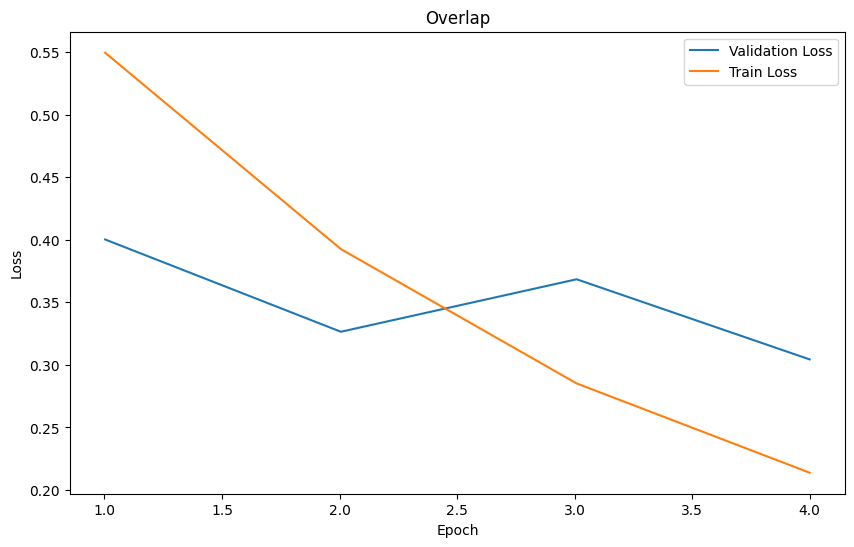

Current SDoH Label: sdoh_community_absent
Number of Labels: 2
Performance on Validation Set: {'eval_loss': 0.3043910562992096, 'eval_accuracy': 0.8975088967971531, 'eval_f1': 0.8974659336064463, 'eval_precision': 0.8974268306897303, 'eval_recall': 0.8975088967971531, 'eval_runtime': 8.0969, 'eval_samples_per_second': 173.523, 'eval_steps_per_second': 2.717, 'epoch': 4.0}
The best model checkpoint is saved at: ./logs/epoch_logs/20240319_172857/pytorch_model.bin


In [12]:
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

# training args - need to adjust
training_args = TrainingArguments(
      output_dir= epoch_logs,  # change to epoch log directory, convert to a text
      logging_strategy='epoch',  # characterize as epoch
      num_train_epochs=4, # have high epoch
      per_device_train_batch_size=16, #reduced batch size
      per_device_eval_batch_size=64,  # gradient accum if batch size of two, 64 approp
      save_strategy= 'epoch',
      warmup_steps=500,
      weight_decay=0.02, #5e-5
      logging_dir= tensor_logs,  # change to tensor logs
      evaluation_strategy="epoch",
      load_best_model_at_end=True,
      metric_for_best_model="eval_loss",
      greater_is_better=False,
      learning_rate=5e-6,
      lr_scheduler_type='linear',

)

trainer = CustomTrainer(
      model=model,
      args=training_args,
      train_dataset=train_dataset,
      eval_dataset=val_dataset,
      compute_metrics=compute_metrics,
      class_weights=class_weights_tensor,
      callbacks=[EarlyStoppingCallback(early_stopping_patience=3)], # 3 is a balance between giving the model enough chance  to improve and stopping early enough to prevent overfitting and unnecessary computation
)

# train the model
trainer.train()

# evaluate the model
evaluation_results = trainer.evaluate()

#readable results
steps_per_epoch = len(train_dataset) // training_args.per_device_train_batch_size
latest_checkpoint = get_latest_checkpoint(epoch_logs) # latest checkpoint update to csv

# Assuming the best checkpoint is saved as 'pytorch_model.bin' in the output_dir
best_checkpoint_path = os.path.join(training_args.output_dir, 'pytorch_model.bin')

# Save metrics to CSV
json_path = os.path.join(latest_checkpoint, 'trainer_state.json') if latest_checkpoint else None
if json_path:
    save_metrics_to_csv(json_path, 'eval_metric.csv')  # update metrics

plot_metric_from_tensor(tensor_logs, 'graphs', steps_per_epoch)

#json_path = os.path.join(latest_checkpoint, 'trainer_state.json')
save_metrics_to_csv(json_path, 'eval_metric.csv') #update metrics
save_directory = "/content/saved_models/gpt2"

os.makedirs(save_directory, exist_ok=True)
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Current SDoH Label: {current_sdoh}")
print(f"Number of Labels: {num_labels}")
print("Performance on Validation Set:", evaluation_results)
# Print the path of the best checkpoint
print(f"The best model checkpoint is saved at: {best_checkpoint_path}")

In [14]:
# TEST DATA
#test_data_path = "/content/ANNOTATEDNOTES.csv"
#test_dataset_df = pd.read_csv(test_data_path)

#text_data = test_dataset_df['TEXT'].tolist()
#sdoh_data = test_dataset_df[current_sdoh].tolist()

test_encodings = tokenizer(text_data, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors='pt')
test_dataset = CustomDataset(test_encodings, sdoh_data)

# Load the model from the best checkpoint for the current SDoH
best_checkpoint_path = os.path.join("/content/logs/epoch_logs/20240319_172857/checkpoint-704")
model = GPT2ForSequenceClassification.from_pretrained(best_checkpoint_path)
model.to(device)

results = trainer.predict(test_dataset)

predicted_labels = results.predictions.argmax(-1)
true_labels = results.label_ids

# Generate a classification report
unique_labels = np.unique(true_labels)
target_names = [str(label) for label in unique_labels]

print(f"Classification Report for {current_sdoh}:\n", classification_report(true_labels, predicted_labels, target_names=target_names))

# metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average="weighted")
recall = recall_score(true_labels, predicted_labels, average="weighted")
f1 = f1_score(true_labels, predicted_labels, average="weighted")

metrics_df = pd.DataFrame({
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
})

print("Metrics Table:\n", metrics_df)

print("True Labels:", true_labels)
print("Predicted Labels:", predicted_labels)

print("Unique Predicted Labels:", np.unique(predicted_labels))
print("Test Dataset Labels:", np.unique(test_dataset.labels))

Classification Report for sdoh_community_absent:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92      2562
           1       0.95      0.96      0.95      4463

    accuracy                           0.94      7025
   macro avg       0.94      0.94      0.94      7025
weighted avg       0.94      0.94      0.94      7025

Metrics Table:
    Accuracy  Precision    Recall  F1 Score
0  0.942349   0.942247  0.942349  0.942283
True Labels: [0 0 1 ... 1 1 1]
Predicted Labels: [0 0 1 ... 1 1 0]
Unique Predicted Labels: [0 1]
Test Dataset Labels: [0 1]


In [15]:
# AUROC (Area under the receiver operating characteristics curve)

from sklearn.metrics import roc_auc_score

logits = results.predictions
probabilities = torch.softmax(torch.from_numpy(logits), dim=-1).numpy()

# Extract probabilities for the positive class
prob = probabilities[:, 1]

# Calculate AUROC
auroc = roc_auc_score(true_labels, prob)

print(f"AUROC: {auroc}")

AUROC: 0.9822267938849448


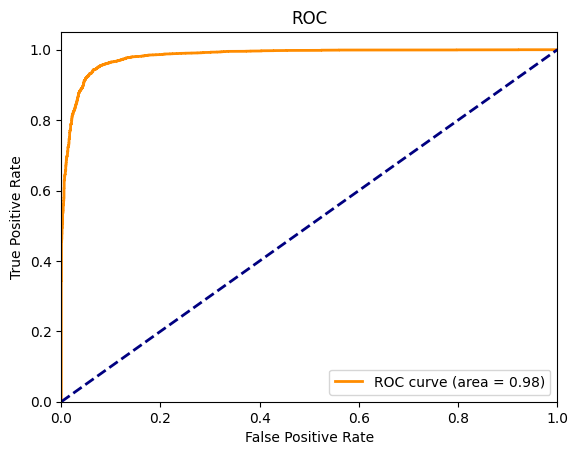

In [16]:
# ROC CURVE
from sklearn.metrics import roc_curve

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, prob)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

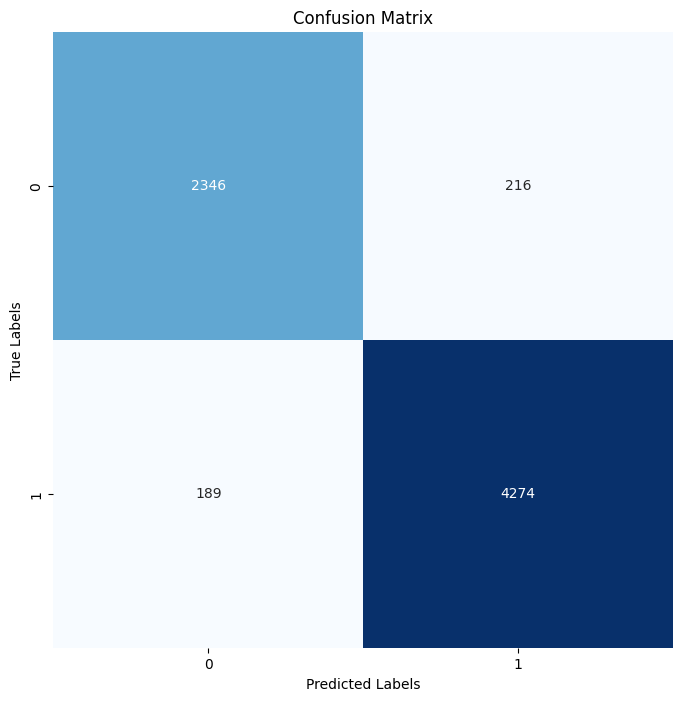

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(true_labels, predicted_labels)

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues', cbar=False)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
plt.show()

In [18]:
# save all testing data into a csv file

# Save classification report to CSV
report = classification_report(true_labels, predicted_labels, target_names=target_names, output_dict=True)
pd.DataFrame(report).transpose().to_csv(f"{current_sdoh}_classification_report.csv")

# Save metrics to CSV
metrics_df.to_csv(f"{current_sdoh}_metrics.csv", index=False)

# Save AUROC to CSV
auroc_df = pd.DataFrame({'AUROC': [auroc]})
auroc_df.to_csv(f"{current_sdoh}_auroc.csv", index=False)

# Since saving the ROC curve plot and confusion matrix plot directly to CSV is not meaningful,
# consider saving their data instead and plotting them later as needed.

# Save ROC curve data to CSV
roc_data = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Thresholds': thresholds})
roc_data.to_csv(f"{current_sdoh}_roc.csv", index=False)

# Save confusion matrix to CSV
cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
cm_df.to_csv(f"{current_sdoh}_cm.csv")